In [5]:
import sys
import os
import glob
import itk
import random
import mermaid
pancreas_paths = glob.glob("../../pancreatic_cancer_registration/data/*/Processed/*/normalized_image.nii.gz")
import mermaid.visualize_registration_results
import matplotlib.pyplot as plt
import numpy as np

abds = [itk.GetArrayFromImage(itk.imread(b)) for b in pancreas_paths]
print("loaded")
abds = [b[::2, ::2, ::2] for b in abds]

abds = [b / np.max(b) for b in abds]

loaded


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import sys
import os
import matplotlib.pyplot as plt
import mermaid.module_parameters as pars
import mermaid.model_factory as py_mf
import mermaid.utils as py_utils
import mermaid.similarity_measure_factory as smf
from mermaid.data_wrapper import AdaptVal
import mermaid.image_sampling as py_is
import mermaid.example_generation as eg

import numpy as np


In [7]:
import matplotlib.pyplot as plt

In [193]:
BATCH_SIZE = 64

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.num_layers = 5   
        down_channels = [2, 16, 16, 32, 64, 128]
        up_channels_out = [8, 8, 16, 32, 64]
        up_channels_in = [24, 32, 64, 128, 128] 
        self.downConvs = nn.ModuleList([])
        self.upConvs = nn.ModuleList([])
        for depth in range(self.num_layers):
            self.downConvs.append( 
                nn.Conv3d(
                    down_channels[depth], 
                    down_channels[depth + 1],
                    kernel_size=3,
                    padding=1,
                    stride=2
                )
            )
            self.upConvs.append(
                nn.ConvTranspose3d(
                    up_channels_in[depth], 
                    up_channels_out[depth],
                    kernel_size=4,
                    padding=1,
                    stride=2
                )
            )
        self.lastConv = nn.Conv3d(
            10, 3, kernel_size=3, padding=1)
        #torch.nn.init.zeros_(self.lastConv.weight)
     
    def forward(self, x, y):
        x = torch.cat([x, y], 1)
        skips = []
        for depth in range(self.num_layers):
            skips.append(x)
            x = F.relu(self.downConvs[depth](x))
        for depth in reversed(range(self.num_layers)):
            x = F.relu(self.upConvs[depth](x))
            x = torch.cat([x, skips[depth]], 1)
        x = self.lastConv(x)
        return x

class MermaidNet(nn.Module):
    def __init__(self):
        super(MermaidNet, self).__init__()       
        
        self.sz = np.array([BATCH_SIZE, 1, 32, 64, 64])
        self.spacing = 1./(self.sz[2::]-1) 
        
        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.identityMap = torch.from_numpy(_id).cuda()
       
        
        self.regis_net = UNet().cuda()
        

    def forward(self, moving_image, fixed_image):
        

        self.phi1 = self.regis_net(moving_image, fixed_image) + self.identityMap
        
        self.phiinv = self.regis_net(fixed_image, moving_image) + self.identityMap
        
        self.warped_moving_image = py_utils.compute_warped_image_multiNC(
            moving_image, self.phi1, self.spacing, 1)
        
        self.warped_fixed_image = py_utils.compute_warped_image_multiNC(
            fixed_image, self.phiinv, self.spacing, 1)
        
        self.fake_ident = py_utils.compute_warped_image_multiNC(
            self.phiinv, self.phi1, self.spacing, 1)
        ll = 160
        regularization_loss = ll * torch.mean(
            (self.identityMap - self.fake_ident)**2)
        self.distortion_magnitude = ll * torch.mean(
            (self.identityMap - self.phi1)**2
        )
        similarity_loss = (
            torch.mean((self.warped_moving_image - fixed_image)**2) + 
            torch.mean((self.warped_fixed_image - moving_image)**2)
        )
        print(regularization_loss.detach().cpu().item(), similarity_loss.detach().cpu().item(), 
             self.distortion_magnitude.detach().cpu().item())
        
        self.all_loss = regularization_loss + similarity_loss


net = MermaidNet()
0

0

In [194]:
optimizer = torch.optim.Adam(net.parameters(), lr=.001)

In [195]:
net.train()

MermaidNet(
  (regis_net): UNet(
    (downConvs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (upConvs): ModuleList(
      (0): ConvTranspose3d(24, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ConvTranspose3d(32, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): ConvTranspose3d(64, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): ConvTranspose3d(128, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (4): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))


In [436]:
def make_batch():
    image = np.array([random.choice(brains)[::2, ::2, ::2] for _ in range(BATCH_SIZE)])
    image = image.reshape(BATCH_SIZE, 1, 32, 64, 64)
    image = torch.tensor(image).cuda()
    return image
for _ in range(10):

    moving_image = make_batch()
    fixed_image = make_batch()
    optimizer.zero_grad()
    net(moving_image, fixed_image)
    loss = net.all_loss

    loss.backward()
    optimizer.step()


0.0019521755166351795 0.014006472192704678 0.13949240744113922
0.002164966193959117 0.01470622792840004 0.1632624715566635
0.0020216426346451044 0.013514095917344093 0.16891232132911682
0.0018193211872130632 0.014081131666898727 0.12987421452999115
0.001896063913591206 0.01371641643345356 0.12775328755378723
0.0020022280514240265 0.0142198596149683 0.15798568725585938
0.0018968520453199744 0.013715063221752644 0.10403040796518326
0.0019236705265939236 0.013386588543653488 0.15366505086421967
0.001935743959620595 0.013502795249223709 0.16047242283821106
0.0020532426424324512 0.014440562576055527 0.14967632293701172


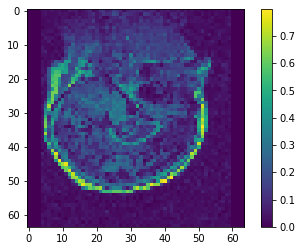

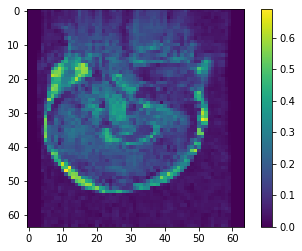

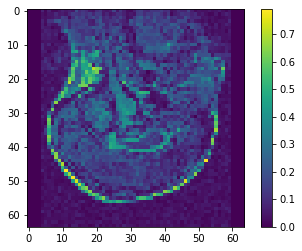

In [450]:
N = 49
plt.imshow(moving_image[N, 0, 16].cpu())
plt.colorbar()
plt.show()
plt.imshow(net.warped_fixed_image[N, 0, 16].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(fixed_image[N, 0, 16].cpu())
plt.colorbar()

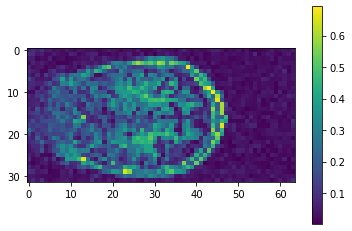

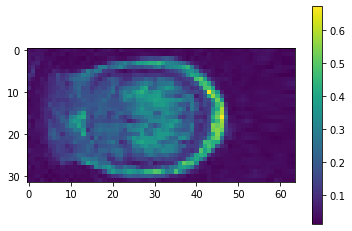

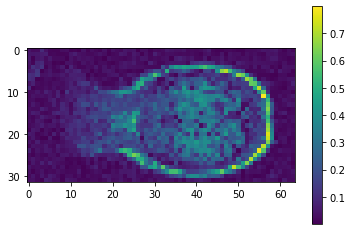

In [438]:
plt.imshow(moving_image[N, 0, :, :, 16].cpu())
plt.colorbar()
plt.show()
plt.imshow(net.warped_fixed_image[N, 0, :, :, 16].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(fixed_image[N, 0, :, :, 16].cpu())
plt.colorbar()

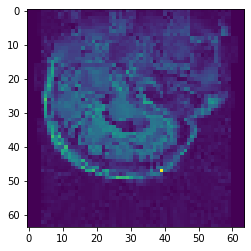

In [439]:

plt.imshow(mermaid.visualize_registration_results.checkerboard_2d(
    net.warped_fixed_image[N, 0, 14].detach().cpu(),
    moving_image[N, 0, 14].cpu()))

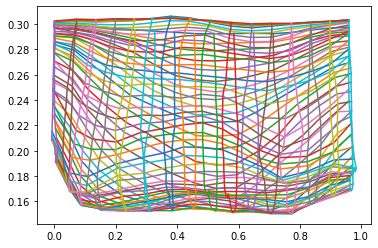

In [449]:
def grid(A, B):
    #plt.axes().set_aspect("equal")
    plt.plot(A, B)
    plt.plot(A.transpose(0, 1), B.transpose(0, 1))
    
def grd(d):
    grid(d[0], d[1])
    
grd(net.phi1[N, :, ::2, 19].detach().cpu())

In [441]:
def get_phi(a, b):
    net(a, b)
    return net.phi1.detach().cpu()

In [442]:
phi2 = get_phi(fixed_image, moving_image)
phi1 = get_phi(moving_image, fixed_image)


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


0.002139302436262369 0.014367099851369858 0.15342628955841064
0.002089915331453085 0.014367099851369858 0.15041208267211914


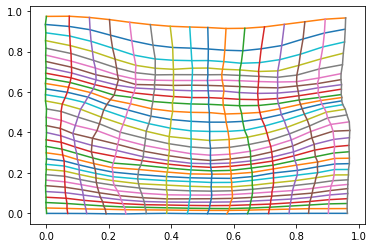

In [443]:
grd(phi1[N, :, ::2, ::2, 16])

In [444]:
ident_hope = py_utils.compute_warped_image_multiNC(phi2, phi1, net.spacing, 1)

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


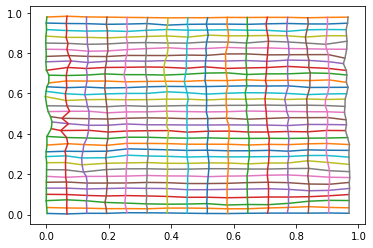

In [445]:
grd(ident_hope[N, :, ::2, ::2, 30])

In [52]:
net.regis_net = rnet

In [285]:
A = torch.tensor([[[[0, 1, 0,], [0., 0, 0]]]])

torch.sum(F.interpolate(A, scale_factor=2, mode="bilinear", align_corners=True))

tensor(4.8000)

In [ ]:
B = torch.tensor([[[1, 2, 1],[2, 4, 2], [1, 2, 1]]])
B = B / torch.sum(B)

In [395]:
torch.save(net.state_dict, "good headaligner")

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MermaidNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [397]:
net.state_dict

<bound method Module.state_dict of MermaidNet(
  (regis_net): UNet(
    (downConvs): ModuleList(
      (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (upConvs): ModuleList(
      (0): ConvTranspose3d(24, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ConvTranspose3d(32, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (2): ConvTranspose3d(64, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): ConvTranspose3d(128, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (4): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), st

In [3]:
images = glob.glob("../../pancreatic_cancer_registration/data/*/Processed/*/normalized_image.nii.gz")

In [4]:
len(images)

360

In [16]:
abds[32].shape

(88, 100, 103)

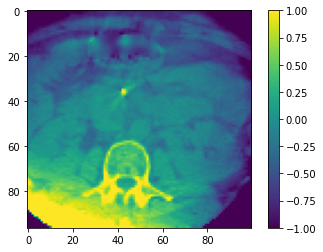

In [68]:
N += 1
plt.imshow(abds[N][40])
plt.colorbar()

In [33]:
pancreas_paths

['../../pancreatic_cancer_registration/data/1822705/Processed/planCT_OG/normalized_image.nii.gz',
 '../../pancreatic_cancer_registration/data/1822705/Processed/CBCT02_OG/normalized_image.nii.gz',
 '../../pancreatic_cancer_registration/data/1822705/Processed/CBCT07_OG/normalized_image.nii.gz',
 '../../pancreatic_cancer_registration/data/1822705/Processed/planCT_EM/normalized_image.nii.gz',
 '../../pancreatic_cancer_registration/data/1822705/Processed/planCT_SM/normalized_image.nii.gz',
 '../../pancreatic_cancer_registration/data/1822705/Processed/CBCT02_EM/normalized_image.nii.gz',
 '../../pancreatic_cancer_registration/data/1822705/Processed/CBCT02_SM/normalized_image.nii.gz',
 '../../pancreatic_cancer_registration/data/1822705/Processed/CBCT07_EM/normalized_image.nii.gz',
 '../../pancreatic_cancer_registration/data/1822705/Processed/CBCT07_SM/normalized_image.nii.gz',
 '../../pancreatic_cancer_registration/data/1822737/Processed/planCT_EM/normalized_image.nii.gz',
 '../../pancreatic_c

In [70]:
mermaid.similarity_measure_factory.LNCCSimilarity?